## Running topic modelling

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk                         # used to preprocess data to insert in topic modelling algorithm
import gensim                       # used to run the topic modelling

import pyLDAvis                     # used to visualise topic modelling results
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [2]:
def tokenize(docs, tokenizer):
    """Tokenize documents, turning string of text in list of words

    Parameters:
    docs (pandas.series): pandas series, each element is one string with title, keyword and abstract of one document.
    tokenizer (nltk.RegexpTokenizer): nltk tokenizer with regex to define how to break string into words.

    Returns:
    list: list of list of strings. Each list of strings contains words of one document.

   """
    docs = [doc.lower() for doc in docs]
    docs = [tokenizer.tokenize(doc) for doc in docs]
    docs = [[d.strip() for d in doc if d.strip()] for doc in docs]
    docs = [' '.join(doc).split(' ') for doc in docs]
    
    return docs

def clen_words(docs, stopwords=set()):
    """Remove stopwords of documents based on method input.

    Parameters:
    docs (list): list of list of strings. Each list of strings contains words of one document.
    stopwords (list): list of stopwords words that should not be passed to topic modelling algorithm.

    Returns:
    list: list of list of strings. Each list of strings contains words of one document.

   """
    bag = [[word for word in doc if valid_word(word, stopwords)] for doc in docs]  
    
    return bag

def valid_word(word, stopwords):
    """Check if a word is valid, used inside clen_words.

    Parameters:
    word (string): Word of one document.
    stopwords (list): list of stopwords words that should not be passed to topic modelling algorithm.

    Returns:
    bool: True if the word is valid and False if the word is not valid.

   """
    return (word not in stopwords and len(word) >= 3 and not word.isnumeric())

def lemmatize(docs, lemmatizer):
    """Lemmatize documents, when necessary replacing words for its lemmas.

    Parameters:
    docs (list): list of list of strings. Each list of strings contains words of one document.
    lemmatizer (nltk.WordNetLemmatizer): object that lemmatize strings.

    Returns:
    list: list of list of strings. Each list of strings contains words of one document.

   """
    return [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [3]:
# Import data and define initial documents
df = pd.read_csv('data/modelling.csv', index_col=0)

# Fill empty Author Keywords values with empty string
df['author_keywords'] = df['author_keywords'].fillna('')
df['abstract'] = df['abstract'].fillna('')

# Make Year and number of citations a integer
df['year'] = df['year'].astype('Int64')
df['number_citation'] = df['number_citation'].astype('Int64')

# Define docs
docs = df['title'] + ' ' + df['abstract'] + ' ' + df['author_keywords']

In [4]:
# Preprocess and clean documents

tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w|\-]+')
docs = tokenize(docs, tokenizer)

new_stopwords = ['research', 'review', 'literature', 'analysis']
stopwords = nltk.corpus.stopwords.words('english') + new_stopwords
docs = clen_words(docs, stopwords)

lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
docs = lemmatize(docs, lemmatizer)

In [5]:
# Add bigrams - sequence of two words - to documents
bigram = gensim.models.Phrases(docs, min_count=30)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            docs[idx].append(token)

In [6]:
# Set parameters of the model
no_below=70; no_above=0.5; keep_n=7000; num_topics = 6; passes=10; iterations=5000; random_state=1

# Create dictionary based on documents and define the corpus
dictionary = gensim.corpora.Dictionary(docs)
dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=keep_n)

corpus = [dictionary.doc2bow(doc) for doc in docs]

# Fit LDA topic model
LDA_model = gensim.models.LdaModel(corpus, id2word=dictionary, passes=passes, 
                                   chunksize=5000, iterations=iterations,
                                   num_topics=num_topics, eval_every=None, random_state=random_state)

# Print results
topics_matrix = LDA_model.show_topics(formatted=False, num_words=7)
for i in topics_matrix:
    print(f'Topic {i[0] + 1}: {[str(pair[0]) for pair in i[1]]}')
    
# Compute model coherence
coherecenmodel = gensim.models.coherencemodel.CoherenceModel(model=LDA_model, texts=docs, coherence='c_v')
print(f'Model coherece {coherecenmodel.get_coherence()}')

Topic 1: ['factor', 'psychological', 'support', 'relationship', 'family', 'social', 'student']
Topic 2: ['specie', 'community', 'effect', 'ecosystem', 'population', 'change', 'response']
Topic 3: ['risk', 'system', 'community', 'supply', 'management', 'disaster', 'approach']
Topic 4: ['network', 'system', 'proposed', 'performance', 'energy', 'method', 'power']
Topic 5: ['climate', 'change', 'water', 'climate_change', 'forest', 'ecosystem', 'area']
Topic 6: ['health', 'stress', 'symptom', 'associated', 'risk', 'depression', 'factor']
Model coherece 0.5731544028125684


In [7]:
# Visualize results
roots_data = pyLDAvis.gensim.prepare(LDA_model, corpus, dictionary)
pyLDAvis.display(roots_data)

## Selecting papers inside topic model

In [8]:
# Based on the result of the topic modelling, fill topic for each paper
df['topic'] = 0
for idx in range(len(corpus)):
    topic_number = sorted(LDA_model[corpus[idx]], reverse=True, key=lambda element: element[1])[0][0] + 1
    df.loc[idx, 'topic'] = int(topic_number)

# Merge Psychology topics
topic1 = 1; topic2 = 6
df.loc[df['topic'] == topic2, 'topic'] = topic1
num_topics = len(df.topic.unique())

df[['title', 'journal_name', 'topic']].assign(tokens=docs).head()

,title,journal_name,topic,tokens
index,,,,
0,Resiliency programming for adult offenders in ...,Education and urban society,3,"[resiliency, programming, adult, offender, geo..."
1,The resilience of changes promoting inclusiven...,Elementary school journal,1,"[resilience, change, promoting, inclusiveness,..."
2,Integrated geographical assessment of environm...,Journal of environmental management,5,"[integrated, geographical, assessment, environ..."
3,Understanding the role of sink patches in sour...,Conservation biology,2,"[understanding, role, sink, patch, source-sink..."
4,Ecosystem stability and resilience: A review o...,"Perspectives in plant ecology, evolution and s...",2,"[ecosystem, stability, resilience, relevance, ..."


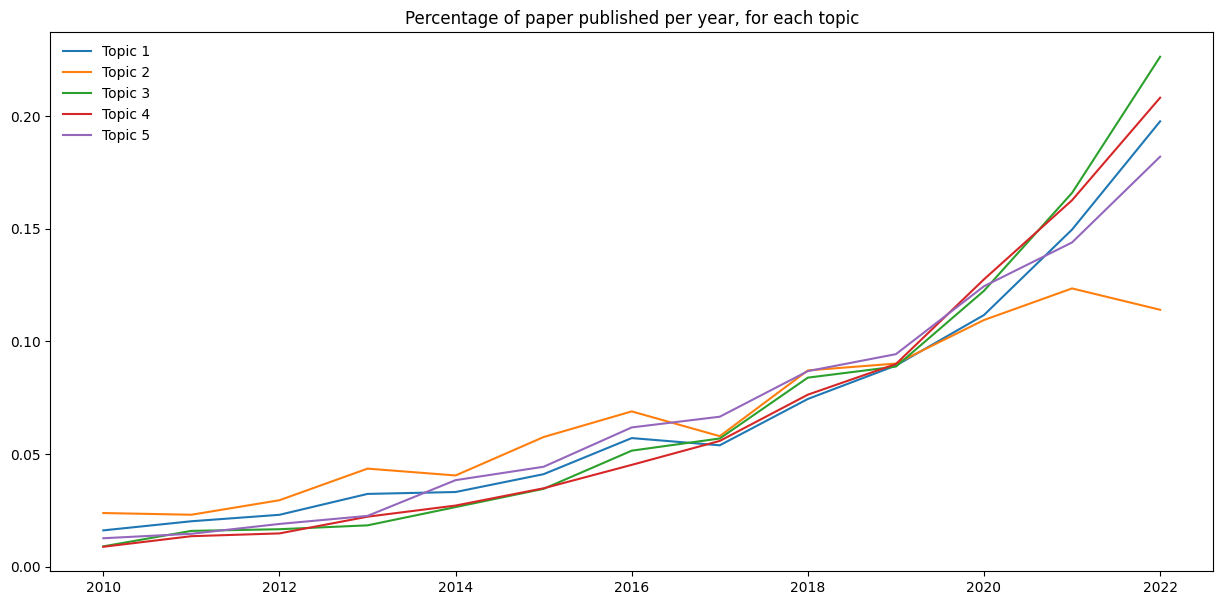

In [9]:
# Plot percentage of publication per year, inside topic
sns.set_context(rc = {'patch.linewidth': 0.0})
plt.figure(figsize=(15, 7))

years = np.arange(2010, 2023)
for topic in range(num_topics):
    dfTopic = df[df['topic'] == topic + 1]
    total_num_results = len(dfTopic)
    num_results = [(dfTopic['year'] == year).sum() / total_num_results for year in years] 
    sns.lineplot(x=years, y=num_results, label=f"Topic {topic + 1}") 

plt.title('Percentage of paper published per year, for each topic')
plt.legend()
plt.show()

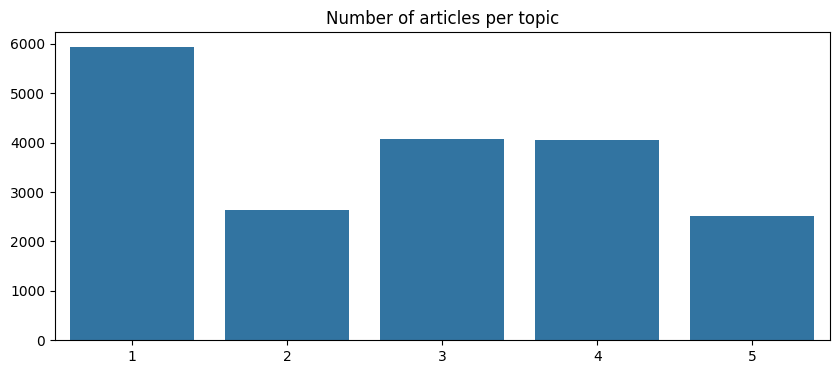

In [10]:
# Plot bar chart of the number of papers in each topic
plt.figure(figsize=(10, 4))

group_size = [len(group) for name, group in df.groupby('topic')]
topic = np.arange(0, num_topics) + 1
sns.barplot(x=topic, y=group_size)

plt.title('Number of articles per topic')
plt.show()

In [11]:
# Print the most frequent journal per topic
number_journals = 20
topics_dictionary = ['Health and Psychology', 'Ecological', 'Urban, disaster and community', 'Power-grid', 'Environmental Science']

topic_data = {}
for topic in range(num_topics):
    dfTopic = df[df['topic'] == topic + 1]
    dfJournalCount = dfTopic['journal_name'].value_counts().head(number_journals)
    topic_data[f'{topics_dictionary[topic]}'] = list(dfJournalCount.index)
    #topic_data[f'{topic + 1} ({topics_dictionary[topic]}) percentage'] = list(dfJournalCount.values / len(dfTopic)) 

dfTopic = pd.DataFrame(topic_data)
dfTopic

,Health and Psychology,Ecological,"Urban, disaster and community",Power-grid,Environmental Science
0,Frontiers in psychology,Plos one,Sustainability,Reliability engineering and system safety,Science of the total environment
1,International journal of environmental researc...,Ecological indicators,International journal of disaster risk reduction,Ieee access,Forest ecology and management
2,Plos one,Science of the total environment,Natural hazards,Engineering structures,Journal of hydrology
3,Journal of affective disorders,Scientific reports,Plos one,Ieee transactions on smart grid,Sustainability
4,Frontiers in psychiatry,Global change biology,International journal of environmental researc...,Ieee transactions on power systems,Ecological indicators
5,Current psychology,Proceedings of the national academy of science...,Journal of cleaner production,Ieee systems journal,Remote sensing
6,Children and youth services review,Frontiers in marine science,Ecology and society,Energies,Forests
7,Bmj open,Ecological modelling,International journal of production research,Sustainability,Environmental research letters
8,Personality and individual differences,Ecology,Sustainable cities and society,Applied energy,Water (switzerland)
9,Bmc public health,Marine ecology progress series,Science of the total environment,International journal of electrical power and ...,Journal of environmental management


In [12]:
# Saving csv with most cited and newer papers per topic
dfReduced = df.drop(columns=['abstract', 'references'])

with pd.ExcelWriter("data/modelling_topics.xlsx") as writer:
    for name, group in dfReduced.groupby('topic'):
        citation = group.sort_values(by=['number_citation'], ascending=False, na_position='last')
        citation.to_excel(writer, sheet_name=f'{topics_dictionary[name-1]}_citation', index=False)

        newer = group.sort_values(by=['year'], ascending=False, na_position='last')
        newer.to_excel(writer, sheet_name=f'{name}_newer', index=False)

/home/vitor/.pyenv/versions/virtual-env-3.11/lib/python3.11/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [13]:
# Alternative method using selected journals

sample_journals = ['Sustainable cities and society', 'Global change biology',  
                   'Ecology and society', 'Ieee transactions on smart grid', 'Water resources management']

# Previously considered journals
#   'Frontiers in psychology', 'Frontiers in psychiatry',
#                  , 'Risk analysis', 'Reliability engineering and system safety',
#                    'International journal of disaster risk reduction',          
#                  'Ecological indicators', 'Ecological applications', 'Journal of hydrology', 
#                    , 'Environmental research letters', 
#                    'Frontiers in marine science', 'Forest ecology and management', 
#                  'Ieee systems journal', 'International journal of production research'
#                  ]


# Save CSV of papers by journal for supplementary analysis
dfReduced = df.drop(columns=['abstract', 'references'])
dfReduced['Included?'] = dfReduced['Reason'] = ''
with pd.ExcelWriter("data/modelling_papers_journal.xlsx") as writer:
    for journal_name in sample_journals:
        dfJournal = dfReduced[dfReduced['journal_name'] == journal_name]
        dfJournal = dfJournal.sort_values(by=['number_citation'], ascending=False, na_position='last')
        dfJournal.to_excel(writer, sheet_name=f'{journal_name}', index=False)


# Print main topics per journal
journal_data = []
for journal_name in sample_journals:
    dfJournal = df[df['journal_name'] == journal_name]
    group_topic = dfJournal[['title', 'topic']].groupby(['topic']).count().sort_values(by=['title'], ascending=False)
    main_topic = group_topic.index[0]
    percentage1  = round(100 * group_topic.iloc[0,0] / len(dfJournal), 2)
    if len(group_topic) > 1:
        secondary_topic = group_topic.index[1]
        percentage2  = round(100 * group_topic.iloc[1,0] / len(dfJournal), 2)
    else:
        secondary_topic = 1
        percentage2 = 0
    journal_data.append([journal_name, topics_dictionary[main_topic-1], percentage1, topics_dictionary[secondary_topic-1], percentage2])

columns = ['Journal Name', 'Main Topic Name', 'Percentage paper in topic', 'Secondary Topic Name', 'Percentage paper in topic']
dfJournal = pd.DataFrame(journal_data, columns=columns)
dfJournal

,Journal Name,Main Topic Name,Percentage paper in topic,Secondary Topic Name,Percentage paper in topic
0,Sustainable cities and society,"Urban, disaster and community",54.10,Power-grid,24.59
1,Global change biology,Ecological,57.50,Environmental Science,42.50
2,Ecology and society,"Urban, disaster and community",65.48,Ecological,19.05
3,Ieee transactions on smart grid,Power-grid,100.00,Health and Psychology,0.00
4,Water resources management,Power-grid,45.28,Environmental Science,43.40


## Validating number of topics

In [14]:
# Define helper function to compute topic diversity
def topic_diversity(topics, number_keywords):
    unique_words = set()
    for topic in topics:
        unique_words = unique_words.union(set(topic[:number_keywords]))
    return len(unique_words) / (number_keywords * len(topics))

In [15]:
# Set parameters of the model
no_below=70; no_above=0.5; keep_n=7000; passes=10; iterations=5000; random_state=1; num_keywords = 30

num_topics_options = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20]

# Create dictionary based on documents and define the corpus
dictionary = gensim.corpora.Dictionary(docs)
dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=keep_n)

corpus = [dictionary.doc2bow(doc) for doc in docs]

# Apply model
LDA_models = {}
LDA_topics = {}
for num_topics in num_topics_options:
    print(f'Running model for num_topics={num_topics}.')
    LDA_models[num_topics] = gensim.models.LdaModel(corpus, id2word=dictionary, passes=passes,
                                       chunksize=5000, iterations=iterations,
                                       num_topics=num_topics, eval_every=None, random_state=random_state)
    shown_topics = LDA_models[num_topics].show_topics(num_topics=num_topics,
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[num_topics] = [[word[0] for word in topic[1]] for topic in shown_topics]

Running model for num_topics=2.
Running model for num_topics=3.
Running model for num_topics=4.
Running model for num_topics=5.
Running model for num_topics=6.
Running model for num_topics=7.
Running model for num_topics=8.
Running model for num_topics=9.
Running model for num_topics=10.
Running model for num_topics=12.
Running model for num_topics=14.
Running model for num_topics=16.
Running model for num_topics=18.
Running model for num_topics=20.


In [16]:
# Compute model performance metrics
coherenceModel = lambda model: gensim.models.coherencemodel.CoherenceModel(
            model=model, texts=docs, dictionary=dictionary, coherence='c_v'
            ).get_coherence()
coherences = [coherenceModel(LDA_models[num_topics]) for num_topics in num_topics_options]

num_keywords_div = 20
diversity = [topic_diversity(LDA_topics[num_topics], num_keywords_div) for num_topics in num_topics_options]

coupled_coherence_diversity = [a*b for a,b in zip(diversity,coherences)]

idx = coupled_coherence_diversity.index(max(coupled_coherence_diversity))
print(f"Maximum coupled coherence and diversity happens for topic {num_topics_options[idx]}")

Maximum coupled coherence and diversity happens for topic 6


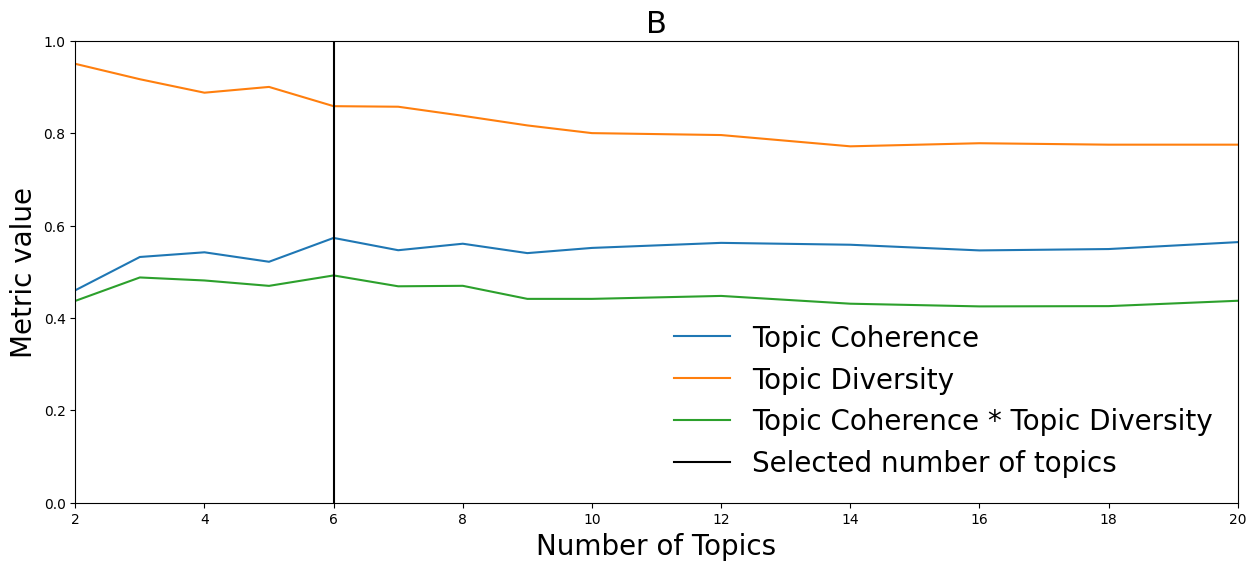

In [17]:
plt.figure(figsize=(15,6))
ax = sns.lineplot(x=num_topics_options, y=coherences, label='Topic Coherence')
ax = sns.lineplot(x=num_topics_options, y=diversity, label='Topic Diversity')
ax = sns.lineplot(x=num_topics_options, y=coupled_coherence_diversity, label='Topic Coherence * Topic Diversity')
ax.axvline(6, color='black', label="Selected number of topics")

ax.set_ylim([0, 1])
ax.set_xlim([2, 20])

ax.set_ylabel('Metric value', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
ax.set_title("B", fontsize=22)
plt.legend(fontsize=20)
plt.savefig('results/modelling_validation_number_topics.png')